# Install Dependencies

In [63]:
# Uncomment the lines below if run in Google Colab
#!pip install pandas==2.2.2
#!pip install torch==2.6.0
#!pip install numpy==2.0.2
#!pip install matplotlib
#!pip install scipy==1.15.3
#!pip install statsmodels==0.14.4

# Import Libraries & Data 

In [64]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import datetime as dt
import random
import scipy
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from scipy.optimize import minimize


# Read the CSV and convert date to datetime
df = pd.read_csv('dji_etc_cc_ohlc_data.csv').drop(columns='Unnamed: 0')
risk_free_rate = pd.read_csv('risk_free_rate.csv')
risk_free_rate.columns = ['date', 'yield']
risk_free_rate.set_index('date', inplace=True)
risk_free_rate = risk_free_rate['yield']/100
risk_free_rate.index = pd.to_datetime(risk_free_rate.index)

df['date'] = pd.to_datetime(df['date'])

# Filter to DJIA tickers drop DOW Inc. due to insufficient data
dji_ticker = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 
              'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 
              'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT', 
              'IGLN.L', 'ISLN.L', 'IPLT.L', 'IPDM.L']

def set_seed(seed):
    """Set all random seeds for reproducibility."""
    random.seed(seed)          # Python
    np.random.seed(seed)       # NumPy
    torch.manual_seed(seed)    # PyTorch CPU
    torch.cuda.manual_seed(seed)       # PyTorch GPU (current CUDA device)
    torch.cuda.manual_seed_all(seed)   # PyTorch GPU (all CUDA devices)
    torch.backends.cudnn.deterministic = True  # CuDNN determinism
    torch.backends.cudnn.benchmark = False     # Disable CuDNN benchmarking

set_seed(12)

In [65]:
# Check Versions
print(f'Pandas Version: {pd.__version__}')
print(f'Numpy Version: {np.__version__}')
print(f'PyTorch Version: {torch.__version__}')
print(f'Scipy Version: {scipy.__version__}')
print(f'Statsmodels Version: {sm.__version__}')

Pandas Version: 2.2.3
Numpy Version: 1.26.0
PyTorch Version: 2.6.0+cpu
Scipy Version: 1.11.3
Statsmodels Version: 0.14.1


# NN & Functions Definition

In [66]:
# -----------------------------------------
# Data Preparation and Feature Engineering
# -----------------------------------------

def prepare_data(long_df,):
    """
    Pivot the long dataframe into a wide format with 'close' prices and calculate
    technical indicators (SMA and RSI) for each asset.
    """
    # Pivot to wide format for close prices only
    # Filter to DJIA tickers
    dji_ticker = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 
                'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 
                'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT', 
                'IGLN.L', 'ISLN.L', 'IPLT.L', 'IPDM.L']
    
    df_filtered = long_df[long_df['tic'].isin(dji_ticker)].reset_index(drop=True)
    wide_df = df_filtered.pivot(index='date', columns='tic', values='close')
    wide_df.columns = [f'close_{col}' for col in dji_ticker]
    wide_df = wide_df.sort_index()
    wide_df = wide_df.ffill().bfill()
    
    # Calculate technical indicators for each ticker
    for tic in dji_ticker:
        close_col = f'close_{tic}'
        # Simple Moving Average (SMA)
        wide_df[f'sma_{tic}'] = wide_df[close_col].rolling(20).mean()
        
        # Relative Strength Index (RSI)
        delta = wide_df[close_col].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(14).mean()
        avg_loss = loss.rolling(14).mean()
        rs = avg_gain / avg_loss
        wide_df[f'rsi_{tic}'] = 100 - (100 / (1 + rs))
    
    return wide_df.bfill()  # Backfill missing values

def extract_features(wide_df, rebalance_date, lookback=252):
    """
    Extract features from a lookback window ending at a given rebalance_date.
    Features include:
      - The latest SMA and RSI values (per ticker)
      - Flattened covariance matrices for the past 1-year of:
            close prices, SMAs, and RSIs.
    """
    lookback_data = wide_df.loc[:rebalance_date].iloc[-lookback:]
    # Get the list of tickers from the columns, assuming they are named like "close_<tic>"
    tics = [col.split('_')[1] for col in wide_df.columns if col.startswith('close_')]
    features = []    
    # Covariance matrices for close, sma, and rsi data
    close_data = lookback_data[[f'close_{tic}' for tic in tics]].values
    sma_data = lookback_data[[f'sma_{tic}' for tic in tics]].values
    rsi_data = lookback_data[[f'rsi_{tic}' for tic in tics]].values
    
    for i in [close_data, sma_data, rsi_data]:
        features.append(i)
    
    return np.array(features)

# -------------------------
# Neural Network Definition
# -------------------------
class TimeSeriesNetwork(nn.Module):
    def __init__(self, num_tickers=33):
        super(TimeSeriesNetwork, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=5, padding=2) # Define first convolutional layer 3 input, 16 outup channels, kernel size 5, padding 2, stride is default 1
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)# Define second convolutional layer 16 input, 32 outup channels, kernel size 3, padding 1, stride is default 1
        self.pool = nn.AdaptiveMaxPool1d(output_size=1) # apply averageing

        self.fc1 = nn.Linear(in_features=32, out_features=16) # Fully connected 1
        self.fc2 = nn.Linear(in_features=16, out_features=1)  # Fully connected 2 Score per ticker

        self.num_tickers = num_tickers

    def forward(self, x):
        # x: (batch, 3, 252, num_tickers)
        batch_size = x.size(0)
        x = x.permute(0, 3, 1, 2)  # shape (batch, num_tickers, 3, 252)
        x = x.reshape(batch_size * self.num_tickers, 3, 252) # shape (batch*num_tickers,3,252)

        x = F.relu(self.conv1(x)) # apply ReLU from given input
        x = F.relu(self.conv2(x)) # apply ReLU from given input
        x = self.pool(x).squeeze(-1)  # (batch*num_tickers, 32)

        x = F.relu(self.fc1(x)) # apply ReLU from given input
        scores = self.fc2(x).view(batch_size, self.num_tickers)  # (batch, num_tickers)

        weights = F.softmax(scores, dim=1).unsqueeze(1)  # scaling output to be positive all summing to 1, shape (batch, 1, num_tickers)
        return weights

#--------------------------
# Loss Function
#--------------------------

def sharpe_ratio_loss(returns, weights, rfr=0.02):
    """
    Compute differentiable Sharpe ratio loss.
    - returns: (batch, time, assets)
    - weights: (batch, 1, assets)
    """
    # Weighted portfolio returns per timestep
    port_returns = (returns * weights).sum(dim=2)  # (batch, time)
    daily_rfr = (1 + rfr) ** (1 / 252) - 1
    excess_returns = port_returns - daily_rfr

    mean_ret = excess_returns.mean(dim=1)
    std_ret = excess_returns.std(dim=1) + 1e-6
    sharpe = mean_ret / std_ret

    return -sharpe.mean()  # negative for minimization

def loss_function(returns, weights, rfr=0.02, reg_lambda=0.01, div_lambda=0.01):
    """
    Sharpe loss + L2 regularization + diversification penalty
    """
    sr_loss = sharpe_ratio_loss(returns, weights, rfr)
    
    # Regularization term
    reg = reg_lambda * (weights ** 2).sum()

    # Entropy-based diversification penalty
    entropy = - (weights * torch.log(weights + 1e-6)).sum(dim=2).mean()
    div_penalty = -div_lambda * entropy

    return sr_loss + reg + div_penalty

# -------------------------
# Training Loop
# -------------------------

def train_model(model, train_features, train_targets, num_epochs=100, lr=0.001, rfr=0.02, reg_lambda=0.001, div_lambda=0.001):
    """
    Train the model on a growing dataset of past lookback windows.
    """
    model.train() # set to training mode
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # define optimizer with learning rate
    dataset = TensorDataset(train_features, train_targets) # make dataset ready 
    loader = DataLoader(dataset, batch_size=16, shuffle=True) # load data

    # learn best weights and biases in an iterative way 1 epoch = 1 iteration over entire test subset
    for epoch in range(num_epochs):
        epoch_loss = []
        for X_batch, y_batch in loader:
            weights = model(X_batch).squeeze(1)  # shape (batch, assets)
            loss = loss_function(y_batch, weights.unsqueeze(1), rfr=rfr, reg_lambda=reg_lambda, div_lambda=div_lambda)

            # evaluate all gradients, backpropagate and update weights and biases here, methodology blows up for these two lines oh my gosh
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())

        # show progress every 50th epoch 
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}: Avg Loss = {-np.mean(epoch_loss):.4f}")
    
    return model
    

# Data Preprocessing

In [67]:
# ---------------------------
# Prepare Base Data and Rebalance Dates
# ---------------------------
long_df = df  # original dataframe
wide_df = prepare_data(long_df)
tics = dji_ticker

# Generate quarter ends within the date range of your DataFrame
quarter_ends = pd.date_range(start=wide_df.index.min(), end=wide_df.index.max(), freq='QE')
indices = wide_df.index.get_indexer(quarter_ends, method='pad')
valid_indices = [i for i in indices if i != -1]
adjusted_dates = wide_df.index[valid_indices]
train_end_dates = adjusted_dates[3:]
train_start_dates = adjusted_dates[:-3]

# Training & Application of NN

In [ ]:
# -----------------------
# initialize
# -----------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_features_list = []
train_targets_list = []

model = TimeSeriesNetwork(num_tickers=len(tics)).to(device)
allocation_weights = []
backtest_dates = []

timer_start = dt.datetime.now()

# iterate through dataset 
for i in range(len(train_end_dates)-1):
    train_end = train_end_dates[i]
    test_start = train_end_dates[i]
    test_end = train_end_dates[i+1]

    # Extract features and returns
    feat = extract_features(wide_df, train_end)  # shape (3,252,num_tickers)
    rets = wide_df[[f'close_{tic}' for tic in tics]].pct_change().fillna(0)
    rets = rets.loc[:train_end].iloc[-252:]
    rets = rets.values  # shape (252,num_tickers)
    rfr = risk_free_rate.loc[:train_end].iloc[-252:].mean()

    # Prepare tensors
    X_tensor = torch.FloatTensor(feat).unsqueeze(0).to(device)      # (1,3,252,num_tickers)
    y_tensor = torch.FloatTensor(rets).unsqueeze(0).to(device)      # (1,252,num_tickers)

    # Add to growing training set
    train_features_list.append(X_tensor)
    train_targets_list.append(y_tensor)

    # Stack all for model training
    all_X = torch.cat(train_features_list, dim=0)
    all_y = torch.cat(train_targets_list, dim=0)

    # Train (fine-tune existing model)
    print(f"\nTraining with data up to {train_end.date()} ({i}/{len(train_end_dates)-2})")
    model = train_model(model, all_X, all_y, num_epochs=200, lr=0.000788, rfr=rfr, reg_lambda=0.001412, div_lambda=0.099556) # Parameters were optimized in 'cnn_paramtuning_thesis.ipynb' script

    # Evaluate on next quarter (apply weights from last trained model)
    with torch.no_grad():
        weights = model(X_tensor).squeeze().cpu().numpy()  # shape (num_tickers,)
        allocation_weights.append(weights)
        backtest_dates.append(test_start)

timer_end = dt.datetime.now()
nn_duration = timer_end-timer_start


Training with data up to 2015-12-31 (0/35)
Epoch 50: Avg Loss = 0.3668
Epoch 100: Avg Loss = 0.3686
Epoch 150: Avg Loss = 0.3692
Epoch 200: Avg Loss = 0.3693

Training with data up to 2016-03-31 (1/35)
Epoch 50: Avg Loss = 0.3704
Epoch 100: Avg Loss = 0.3707
Epoch 150: Avg Loss = 0.3709
Epoch 200: Avg Loss = 0.3710

Training with data up to 2016-06-30 (2/35)
Epoch 50: Avg Loss = 0.3776
Epoch 100: Avg Loss = 0.3781
Epoch 150: Avg Loss = 0.3783
Epoch 200: Avg Loss = 0.3784

Training with data up to 2016-09-30 (3/35)
Epoch 50: Avg Loss = 0.3879
Epoch 100: Avg Loss = 0.3884
Epoch 150: Avg Loss = 0.3886
Epoch 200: Avg Loss = 0.3887

Training with data up to 2016-12-30 (4/35)
Epoch 50: Avg Loss = 0.4039
Epoch 100: Avg Loss = 0.4041
Epoch 150: Avg Loss = 0.4043
Epoch 200: Avg Loss = 0.4044

Training with data up to 2017-03-31 (5/35)
Epoch 50: Avg Loss = 0.4163
Epoch 100: Avg Loss = 0.4167
Epoch 150: Avg Loss = 0.4169
Epoch 200: Avg Loss = 0.4170

Training with data up to 2017-06-30 (6/35)
Ep

In [69]:
nn_duration

datetime.timedelta(seconds=347, microseconds=628228)

# Application of Markowitz

In [70]:

# ------------------------
# 3. OPTIMIZATION WITH SCIPY
# ------------------------

def negative_sharpe_ratio(weights, mu, sigma, rfr):
    port_return = np.dot(weights, mu)
    port_vol = np.sqrt(weights.T @ sigma @ weights)
    return -(port_return - rfr) / port_vol  # Minimize negative Sharpe ratio

def exctract_markowitz_features(returns, rebalance_date, lookback=252):
    looback_returns = returns.loc[:rebalance_date].iloc[-lookback:]
    return looback_returns

prices = wide_df[[f'close_{tic}' for tic in tics]]
rets = prices.pct_change().fillna(0)
n_assets = len(tics)

# Constraints
constraints = (
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # Fully invested
    {"type": "ineq", "fun": lambda w: w - 0.01}      # Minimum 1% allocation
)

# Bounds: 0.01 <= w_i <= 1 (no shorting)
bounds = [(0.01, 1) for _ in range(n_assets)]

# Initial guess (equal weights)
marko_initial_weights = np.ones(n_assets) / n_assets

marko_optimal_weights_list = []

# ----------------------
# 2. INPUT ESTIMATION
# ----------------------
timer_start = dt.datetime.now()

for i in range(len(train_end_dates)-1):
    train_end = train_end_dates[i]
    test_start = train_end_dates[i]
    test_end = train_end_dates[i+1]  

    returns = exctract_markowitz_features(rets, train_end)
    mu = returns.mean().values * 252  # Annualized returns
    Sigma = returns.cov().values * 252  # Covariance matrix
    rfr = risk_free_rate.loc[:train_end].iloc[-252:].mean()
    
    # Solve
    result = minimize(
        negative_sharpe_ratio,
        marko_initial_weights,
        args=(mu, Sigma,rfr),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"maxiter": 1000}
    )

    marko_optimal_weights = result.x.round(4)

    marko_optimal_weights_list.append(marko_optimal_weights)

timer_end = dt.datetime.now()
marko_duration = timer_end-timer_start

C:\Users\ulfer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [71]:
marko_duration

datetime.timedelta(microseconds=523097)

# Evaluation

# Herfindahl-Hirschman Index

In [72]:
def get_quarter(date):
    """Returns quarter string (Q1, Q2, Q3, Q4) for a given date"""
    quarter = (date.month - 1) // 3 + 1
    return f'Q{quarter}-{date.year}'

C:\Users\ulfer\AppData\Local\Temp\ipykernel_38068\3993580574.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(avg_quarterly_vol.index, rotation=45, ha='right')


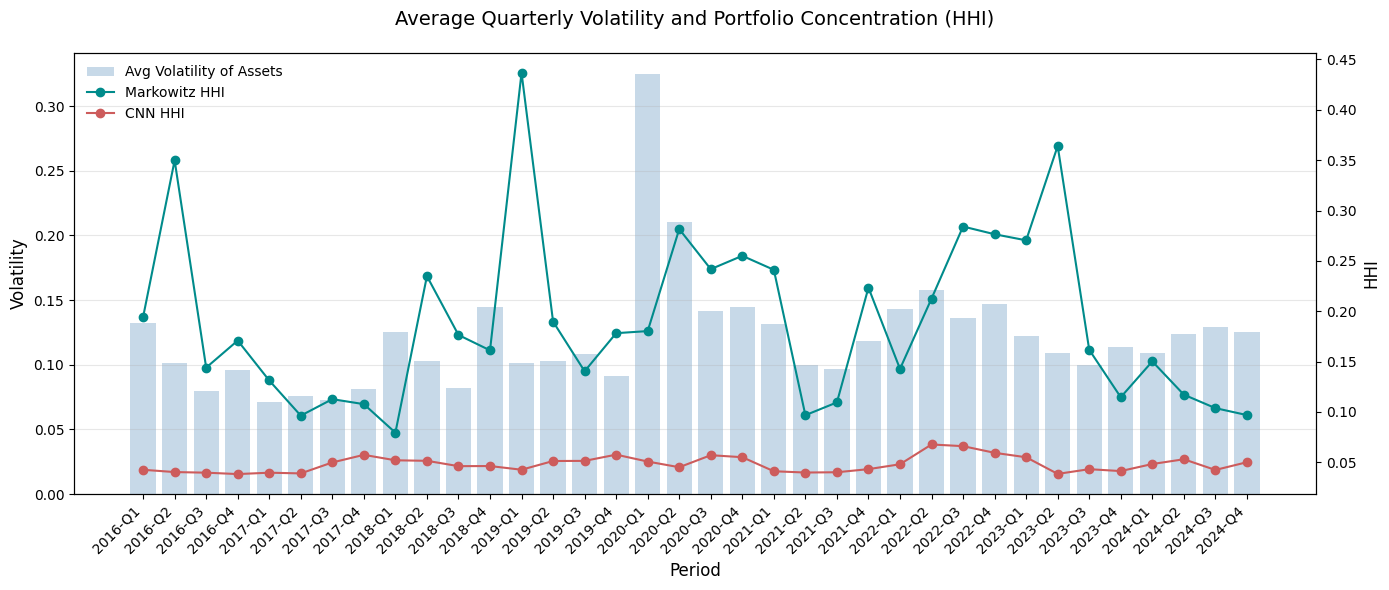

In [73]:
# Create a DataFrame of weights 
dates_index = [f'{get_quarter(train_end_dates[i+1])}' for i in range(len(train_end_dates)-1)]
marko_weights_df = pd.DataFrame(marko_optimal_weights_list, columns=tics, index=dates_index)
nn_weights_df = pd.DataFrame(allocation_weights, columns=tics, index=dates_index)

# Compute Herfindahl-Hirschman Index: sum of squares of weights per period
marko_hhi_series = marko_weights_df.apply(lambda row: np.sum(row**2), axis=1)
nn_hhi_series = nn_weights_df.apply(lambda row: np.sum(row**2), axis=1)

# Calculate daily returns for all close columns
returns_df = wide_df.filter(regex='close_').pct_change().loc['2016':]
# Group by Year-Quarter and calculate annualized volatility
quarterly_vol = (returns_df.groupby([returns_df.index.year, returns_df.index.quarter]).std() * np.sqrt(63))
# Average across all assets
avg_quarterly_vol = quarterly_vol.mean(axis=1)
# Convert MultiIndex to readable format (e.g., "2023-Q1")
avg_quarterly_vol.index = [f"{year}-Q{quarter}" for year, quarter in avg_quarterly_vol.index]

# Create the figure with dual axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Quarterly Volatility (Bars, Left Y-axis)
color_vol = 'steelblue'
ax1.bar(
    avg_quarterly_vol.index, 
    avg_quarterly_vol.values, 
    color=color_vol, 
    alpha=0.3, 
    label='Avg Volatility of Assets'
)
ax1.set_xlabel('Period', fontsize=12)
ax1.set_ylabel('Volatility', fontsize=12)
ax1.tick_params(axis='y')
ax1.set_xticklabels(avg_quarterly_vol.index, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Plot HHI (Lines, Right Y-axis)
ax2 = ax1.twinx()  # Instantiate a second y-axis
color_hhi_marko = 'darkcyan'
color_hhi_nn = 'indianred'
ax2.plot(
    avg_quarterly_vol.index, 
    marko_hhi_series.values, 
    marker='o', 
    linestyle='-', 
    color=color_hhi_marko, 
    label='Markowitz HHI'
)
ax2.plot(
    avg_quarterly_vol.index, 
    nn_hhi_series.values, 
    marker='o', 
    linestyle='-', 
    color=color_hhi_nn, 
    label='CNN HHI'
)
ax2.set_ylabel('HHI', fontsize=12)
ax2.tick_params(axis='y')

# Add Legends & Title
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, 
    labels1 + labels2, 
    loc='upper left', 
    fontsize=10, 
    frameon=False
)
plt.title('Average Quarterly Volatility and Portfolio Concentration (HHI)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# HHI Analysis

In [74]:
# EMM HHI
marko_hhi_series.describe()

count    36.000000
mean      0.189701
std       0.084726
min       0.079483
25%       0.116576
50%       0.173686
75%       0.241320
max       0.436713
dtype: float64

In [75]:
# CNN HHI
nn_hhi_series.describe()

count    36.000000
mean      0.048135
std       0.007800
min       0.038372
25%       0.041299
50%       0.047223
75%       0.052308
max       0.067749
dtype: float64

# EMM Weights

In [76]:
# All assets weights descriptive stats
marko_weights_df.stack().describe()

count    1188.000000
mean        0.030303
std         0.069529
min         0.010000
25%         0.010000
50%         0.010000
75%         0.010000
max         0.657700
dtype: float64

In [77]:
# Commodities weights descriptive stats
marko_weights_df[['IGLN.L', 'ISLN.L', 'IPLT.L', 'IPDM.L']].sum(axis=1).describe()

count    36.000000
mean      0.061381
std       0.046852
min       0.040000
25%       0.040000
50%       0.040000
75%       0.051975
max       0.227100
dtype: float64

# CNN Weights

In [78]:
# All assets weights descriptive stats
nn_weights_df.stack().describe()

count    1188.000000
mean        0.030303
std         0.023256
min         0.001353
25%         0.014315
50%         0.024262
75%         0.039901
max         0.192422
dtype: float64

In [79]:
# Commodities weights descriptive stats
nn_weights_df[['IGLN.L', 'ISLN.L', 'IPLT.L', 'IPDM.L']].sum(axis=1).describe()

count    36.000000
mean      0.102974
std       0.024421
min       0.065287
25%       0.081892
50%       0.102641
75%       0.118468
max       0.153305
dtype: float64

# Weight Allocations

C:\Users\ulfer\AppData\Local\Temp\ipykernel_38068\4242209714.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(tics))


<Figure size 1400x600 with 0 Axes>

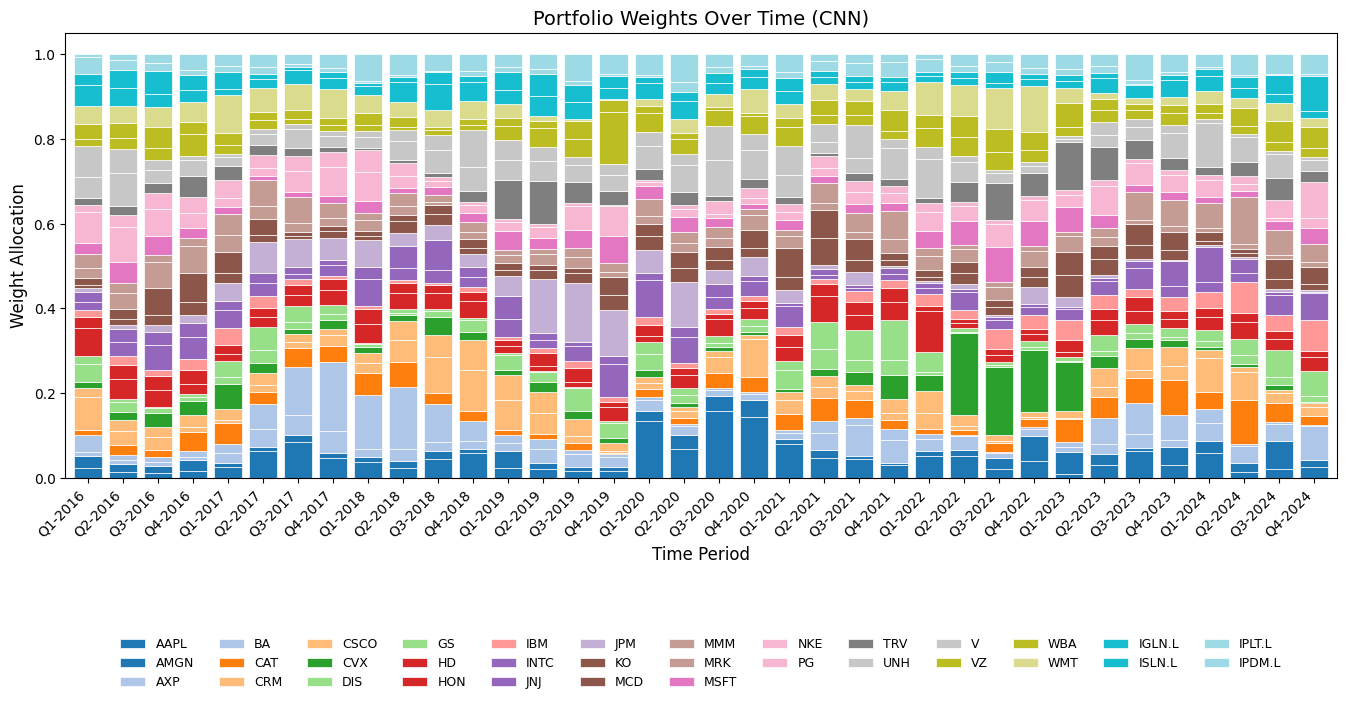

In [80]:
# Create a custom color map for each stock (consistent across time)
colors = plt.cm.get_cmap('tab20', len(tics)) 
stock_colors = {tic: colors(i) for i, tic in enumerate(tics)}

# Plot stacked bars
plt.figure(figsize=(14, 6))
nn_weights_df.plot(kind='bar', stacked=True, color=[stock_colors[tic] for tic in tics], width=0.8, figsize=(14,8), edgecolor='white', linewidth=0.5)
plt.title('Portfolio Weights Over Time (CNN)', fontsize=14)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Weight Allocation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=min(13, len(tics)), frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

C:\Users\ulfer\AppData\Local\Temp\ipykernel_38068\3323873143.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(tics))


<Figure size 1400x600 with 0 Axes>

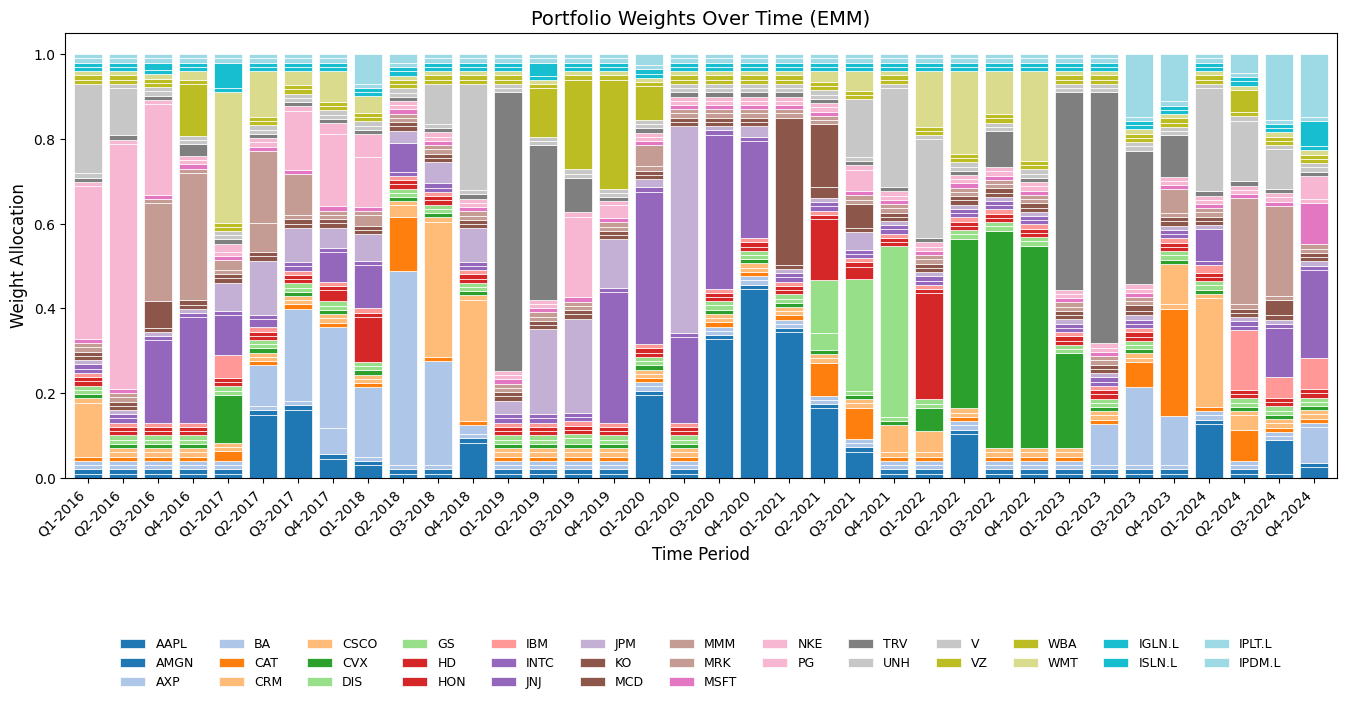

In [81]:
# Create a custom color map for each stock (consistent across time)
colors = plt.cm.get_cmap('tab20', len(tics)) 
stock_colors = {tic: colors(i) for i, tic in enumerate(tics)}

# Plot stacked bars
plt.figure(figsize=(14, 6))
marko_weights_df.plot(kind='bar', stacked=True, color=[stock_colors[tic] for tic in tics], width=0.8, figsize=(14,8), edgecolor='white', linewidth=0.5)
plt.title('Portfolio Weights Over Time (EMM)', fontsize=14)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Weight Allocation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=min(13, len(tics)), frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

# Cummulative Return Chart

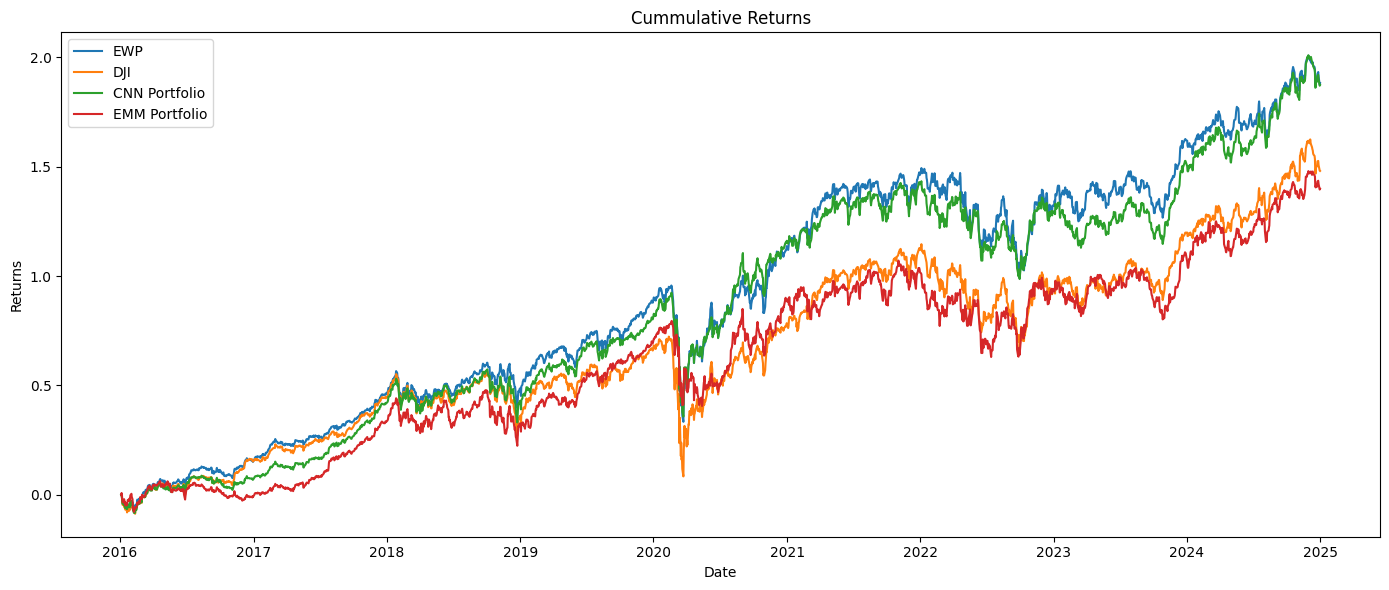

In [92]:
start = adjusted_dates[3]
end = adjusted_dates[-1]
dow = pd.read_csv('./dow_jones_index.csv')
dow['Date'] = pd.to_datetime(dow['Date'])
dow = dow.set_index('Date')['^DJI'].loc['2016':]
dow_index_ret = dow.pct_change().fillna(0)
dow_index_cum_ret  = (dow_index_ret+1).cumprod()-1

weighted_ret_list = []
marko_weighted_ret_list = []
equal_weighted_ret_list = []

capital_nn = 1000
capital_marko = 1000
capital_equal = 1000

nn_cap_ret_list = []
marko_cap_ret_list = []
equal_cap_ret_list = []

transaction_cost = 0.001

for i in range(len(train_end_dates)-1):

    returns_all = wide_df[[f'close_{tic}' for tic in tics]].loc[train_end_dates[i]:train_end_dates[i+1]].pct_change().dropna()
    returns_subset = returns_all.loc[train_end_dates[i]:train_end_dates[i+1]]

    # Rebalance only quarterly no daily adjustments
    # CNN
    capital_nn *= (1 - transaction_cost)
    nn_allocated_capital = allocation_weights[i]*capital_nn
    nn_capital_returns = (returns_subset+1).cumprod() @ nn_allocated_capital
    nn_cap_ret_list.append(nn_capital_returns)
    capital_nn = nn_capital_returns.values[-1]

    # EMM
    capital_marko *= (1 - transaction_cost)
    marko_allocated_capital = marko_optimal_weights_list[i]*capital_marko
    marko_capital_returns = (returns_subset+1).cumprod() @ marko_allocated_capital
    marko_cap_ret_list.append(marko_capital_returns)
    capital_marko = marko_capital_returns.values[-1]

    # EWP
    capital_equal *= (1 - transaction_cost)
    equal_allocated_capital = (np.ones(len(allocation_weights[0]))/len(allocation_weights[0]))*capital_equal
    equal_capital_returns = (returns_subset+1).cumprod() @ equal_allocated_capital
    equal_cap_ret_list.append(equal_capital_returns)
    capital_equal = equal_capital_returns.values[-1]


nn_cap_ret_df = pd.concat(nn_cap_ret_list)
marko_cap_ret_df = pd.concat(marko_cap_ret_list)
equal_cap_ret_df = pd.concat(equal_cap_ret_list)

nn_returns = nn_cap_ret_df.pct_change().fillna(0)
marko_returns = marko_cap_ret_df.pct_change().fillna(0)
equal_returns = equal_cap_ret_df.pct_change().fillna(0)

nn_cummulative_returns = (nn_returns+1).cumprod()-1
marko_cummulative_returns = (marko_returns+1).cumprod()-1
equal_cummulative_returns = (equal_returns+1).cumprod()-1

plt.figure(figsize=(14,6))
plt.plot(equal_cummulative_returns, label='EWP')
plt.plot(dow_index_cum_ret, label='DJI')
plt.plot(nn_cummulative_returns, label='CNN Portfolio')
plt.plot(marko_cummulative_returns, label='EMM Portfolio')
plt.title('Cummulative Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.tight_layout()
plt.show()

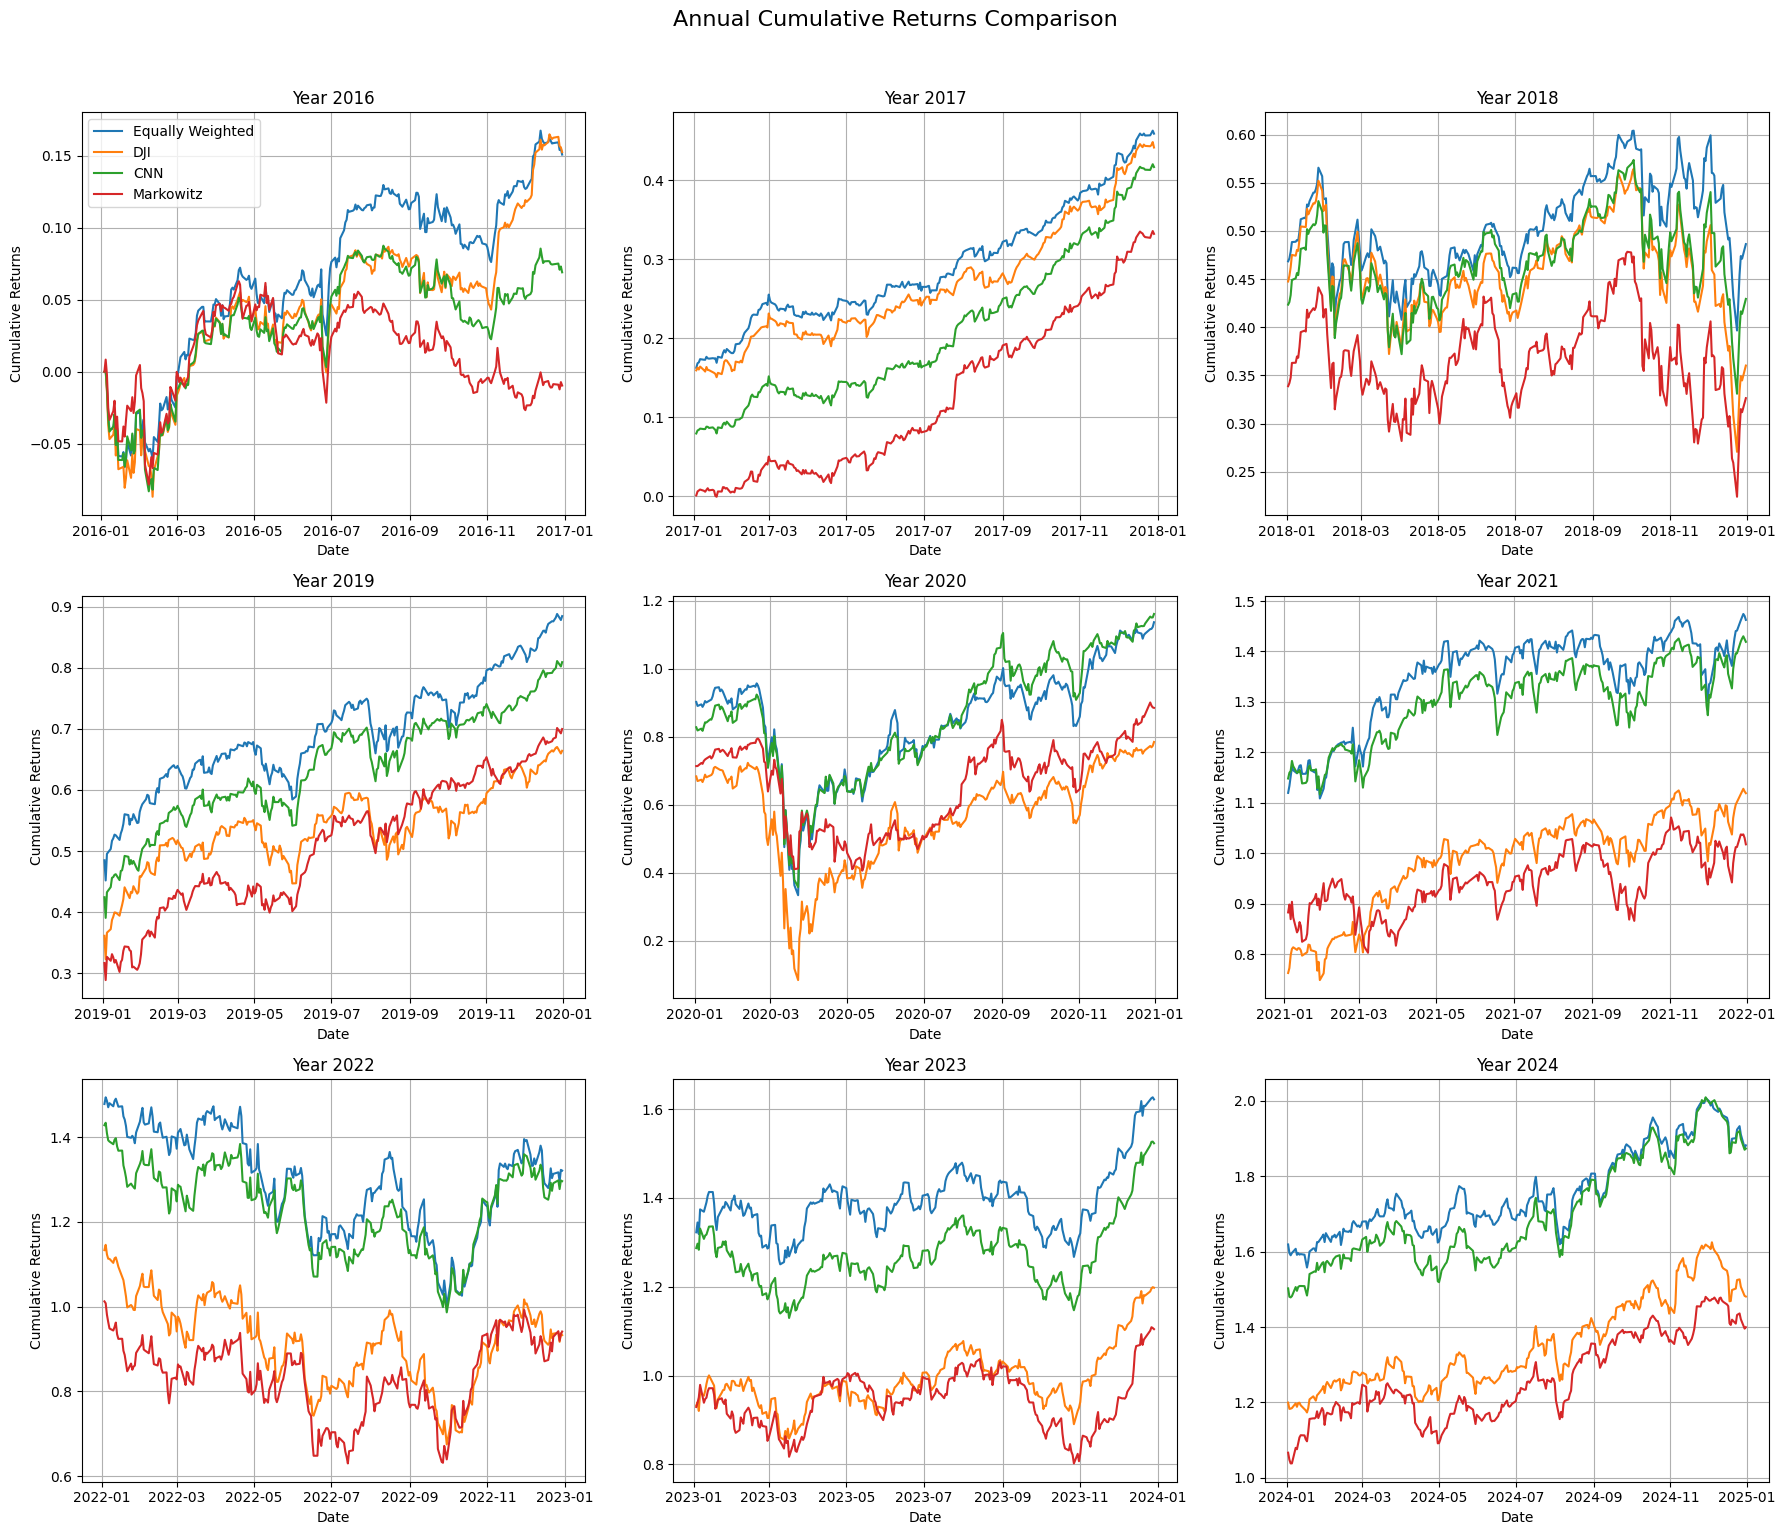

In [93]:
# Create figure with 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Annual Cumulative Returns Comparison', y=1.02, fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Get all unique years in the data
years = pd.to_datetime(nn_cummulative_returns.index).year.unique()

# Make sure we only plot up to 9 years (for 3x3 grid)
years = years[:9]

for i, year in enumerate(years):
    # Filter data for the current year
    year_mask = nn_cummulative_returns.index.year == year
    ax = axes[i]
    
    # Plot each portfolio's cumulative returns for the year
    ax.plot(equal_cummulative_returns[year_mask], label='Equally Weighted')
    ax.plot(dow_index_cum_ret[dow_index_cum_ret.index.year == year], label='DJI')
    ax.plot(nn_cummulative_returns[year_mask], label='CNN')
    ax.plot(marko_cummulative_returns[year_mask], label='Markowitz')
    
    # Customize subplot
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    ax.grid(True)
    
    # Only show legend on first subplot to avoid repetition
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

# Metrics Comparison

In [84]:


def calculate_metrics(daily_returns, daily_benchmark_returns, risk_free_rate=0.02478):
    metrics = {}

    # Cumulative Returns
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    metrics['Cumulative Returns'] = np.round(cumulative_returns.iloc[-1], 4)

    # Annualized Return
    total_periods = len(daily_returns)
    annual_factor = 252
    annual_return = (1 + cumulative_returns.iloc[-1]) ** (annual_factor / total_periods) - 1
    metrics['Annual Return'] = np.round(annual_return, 4)

    # Annualized Volatility
    annual_volatility = daily_returns.std() * np.sqrt(annual_factor)
    metrics['Annual Volatility'] = np.round(annual_volatility, 4)

    # Sharpe Ratio (annualized)
    sharpe = (annual_return - risk_free_rate) / annual_volatility
    metrics['Sharpe Ratio'] = np.round(sharpe, 4)

    # Drawdown and Max Drawdown
    running_max = (1 + daily_returns).cumprod().cummax()
    drawdown = (1 + daily_returns).cumprod() / running_max - 1
    max_drawdown = drawdown.min()
    metrics['Maximum Drawdown'] = np.round(max_drawdown, 4)

    # Calmar Ratio (annualized return / max drawdown)
    calmar = annual_return / abs(max_drawdown)  # Use absolute value of max drawdown
    metrics['Calmar Ratio'] = np.round(calmar, 4)

    # Skewness and Kurtosis
    metrics['Skewness'] = np.round(skew(daily_returns), 4)
    metrics['Kurtosis'] = np.round(kurtosis(daily_returns, fisher=True), 4)

    # Alpha and Beta (CAPM regression with excess returns)
    aligned = pd.concat([daily_returns, daily_benchmark_returns], axis=1).dropna()
    asset = aligned.iloc[:, 0]
    benchmark = aligned.iloc[:, 1]

    # Convert annual risk-free rate to daily
    risk_free_rate_daily = (1 + risk_free_rate) ** (1/annual_factor) - 1  # Exact daily rate
    asset_excess = asset - risk_free_rate_daily
    benchmark_excess = benchmark - risk_free_rate_daily

    # CAPM regression (excess returns)
    X = sm.add_constant(benchmark_excess)
    model = sm.OLS(asset_excess, X).fit()
    alpha_daily = model.params.iloc[0]
    alpha_annualized = (1 + alpha_daily) ** annual_factor - 1  # Compound alpha
    metrics['Alpha'] = np.round(alpha_annualized, 4)
    metrics['Beta'] = np.round(model.params.iloc[1], 4)

    return pd.Series(metrics)


# Overall Metrics


In [100]:
ret_dfs = [nn_returns, marko_returns, equal_returns, dow_index_ret]
strategy_names = ['CNN', 'EMM', 'EWP', 'DJI']
performance_list = []
rfr_mean = risk_free_rate.mean() # Average of risk-free-rate 

# Performance calculation for each approach
for i in range(len(ret_dfs)):

    performance_measures = calculate_metrics(
        daily_returns=ret_dfs[i],
        daily_benchmark_returns=dow_index_ret,
        risk_free_rate=rfr_mean
    )
    performance_list.append(performance_measures)

# Create performance DataFrame
performance_df = pd.concat(performance_list, axis=1)
performance_df.columns = strategy_names

In [102]:
performance_df

,CNN,EMM,EWP,DJI
Cumulative Returns,1.8737,1.3994,1.8822,1.4809
Annual Return,0.1218,0.1000,0.1221,0.1064
Annual Volatility,0.1536,0.1646,0.1556,0.1774
Sharpe Ratio,0.6315,0.4569,0.6257,0.4602
Maximum Drawdown,-0.2944,-0.2167,-0.3185,-0.3709
Calmar Ratio,0.4137,0.4612,0.3835,0.2870
Skewness,-0.6472,-0.4281,-0.6776,-0.5948
Kurtosis,17.4870,6.6436,21.7284,22.2809
Alpha,0.0268,0.0169,0.0246,0.0000
Beta,0.8292,0.7343,0.8654,1.0000


## Per Year Metrics

In [103]:
# Find common index across all return series
common_index = nn_returns.index
for df in ret_dfs[1:]:  
    common_index = common_index.intersection(df.index)


# Align all return series to common dates
aligned_ret_dfs = []
for df in ret_dfs:
    aligned_df = df.reindex(common_index).fillna(0)  # Fill missing with 0 returns
    aligned_ret_dfs.append(aligned_df)

# Get all unique years in the aligned data
years = pd.to_datetime(common_index).year.unique()
years = years[:9]  # Limit to 9 years 
yearly_performance = {}

for year in years:
    # Create mask for current year
    year_mask = common_index.year == year
    
    performance_list = []
    
    for i in range(len(aligned_ret_dfs)):
        # Get returns for current strategy
        strategy_returns = aligned_ret_dfs[i][year_mask]
        # Get benchmark returns (last one in list is benchmark)
        benchmark_returns = aligned_ret_dfs[-1][year_mask]
        
        # Calculate metrics (skip benchmark for itself)
        performance_measures = calculate_metrics(
            daily_returns=strategy_returns,
            daily_benchmark_returns=benchmark_returns,
            risk_free_rate=rfr_mean
        )
        performance_list.append(performance_measures)
    
    # Create DataFrame for this year's performance
    performance_df = pd.concat(performance_list, axis=1)
    performance_df.columns = strategy_names  # Exclude benchmark
    
    # Store in dictionary
    yearly_performance[year] = performance_df.T

# Create combined multi-year DataFrame
all_years_metrics = pd.concat(yearly_performance, axis=0)
all_years_metrics.index.names = ['Year', 'Portfolio']


In [106]:
all_years_metrics

Cumulative Returns  Annual Return  Annual Volatility  \
Year Portfolio                                                         
2016 CNN                    0.0639         0.0639             0.1182   
     EMM                   -0.0160        -0.0160             0.1205   
     EWP                    0.1502         0.1502             0.1123   
     DJI                    0.1524         0.1524             0.1250   
2017 CNN                    0.3222         0.3237             0.0636   
     EMM                    0.3420         0.3436             0.0730   
     EWP                    0.2654         0.2666             0.0569   
     DJI                    0.2508         0.2519             0.0663   
2018 CNN                    0.0089         0.0090             0.1763   
     EMM                   -0.0047        -0.0048             0.2094   
     EWP                    0.0182         0.0183             0.1527   
     DJI                   -0.0563        -0.0565             0.1790   
2019 CNN                    0.2655         0.2655             0.1078   
     EMM                    0.2819         0.2819             0.1137   
     EWP                    0.2676         0.2676             0.1078   
     DJI                    0.2234         0.2234             0.1244   
2020 CNN                    0.1874         0.1866             0.2987   
     EMM                    0.1053         0.1048             0.2700   
     EWP                    0.1295         0.1289             0.3221   
     DJI                    0.0725         0.0722             0.3676   
2021 CNN                    0.1153         0.1153             0.1220   
     EMM                    0.0630         0.0630             0.1489   
     EWP                    0.1479         0.1479             0.1151   
     DJI                    0.1873         0.1873             0.1243   
2022 CNN                   -0.0517        -0.0519             0.1708   
     EMM                   -0.0384        -0.0385             0.2178   
     EWP                   -0.0591        -0.0593             0.1801   
     DJI                   -0.0878        -0.0881             0.1982   
2023 CNN                    0.0978         0.0986             0.1046   
     EMM                    0.0839         0.0846             0.1280   
     EWP                    0.1292         0.1303             0.1096   
     DJI                    0.1370         0.1382             0.1141   
2024 CNN                    0.1395         0.1395             0.1098   
     EMM                    0.1407         0.1407             0.1180   
     EWP                    0.0994         0.0994             0.1029   
     DJI                    0.1288         0.1288             0.1137   

                Sharpe Ratio  Maximum Drawdown  Calmar Ratio  Skewness  \
Year Portfolio                                                           
2016 CNN              0.3314           -0.0842        0.7592   -0.2935   
     EMM             -0.3382           -0.0913       -0.1750   -0.8866   
     EWP              1.1169           -0.0665        2.2586   -0.1919   
     DJI              1.0211           -0.0873        1.7452   -0.4043   
2017 CNN              4.7004           -0.0319       10.1356   -0.0282   
     EMM              4.3658           -0.0319       10.7628    0.1333   
     EWP              4.2526           -0.0260       10.2420   -0.0899   
     DJI              3.4279           -0.0337        7.4811   -0.1645   
2018 CNN             -0.0897           -0.1539        0.0582   -0.2352   
     EMM             -0.1410           -0.1719       -0.0277   -0.0819   
     EWP             -0.0425           -0.1288        0.1420   -0.4591   
     DJI             -0.4541           -0.1877       -0.3011   -0.4478   
2019 CNN              2.2333           -0.0516        5.1484   -0.4469   
     EMM              2.2615           -0.0453        6.2180   -0.3796   
     EWP              2.2527           -0.0561        4.7730   -0.5362   
     DJI             

# Miscelaneous

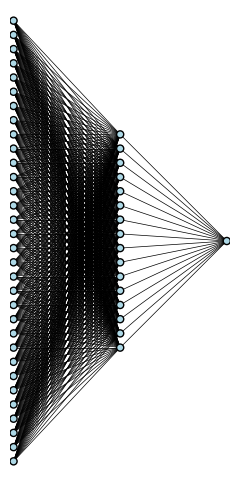

In [89]:

def draw_neural_net(ax, layer_sizes):
    v_spacing = 4
    h_spacing = 30
    radius = 1

    # Calculate vertical position of each layer
    n_layers = len(layer_sizes)
    layer_positions = []
    for i, layer_size in enumerate(layer_sizes):
        total_height = (layer_size - 1) * v_spacing
        positions = [(i * h_spacing, -total_height / 2 + j * v_spacing) for j in range(layer_size)]
        layer_positions.append(positions)

    # Draw connections
    for l in range(n_layers - 1):
        for (x1, y1) in layer_positions[l]:
            for (x2, y2) in layer_positions[l + 1]:
                ax.plot([x1, x2], [y1, y2], 'k-', linewidth=0.5)

    # Draw neurons
    for layer in layer_positions:
        for (x, y) in layer:
            circle = plt.Circle((x, y), radius, color='lightblue', ec='black', zorder=3)
            ax.add_patch(circle)

    # Adjust the plot
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_xlim(-1, h_spacing * (n_layers - 1) + 1)
    max_layer = max(layer_sizes)
    ax.set_ylim(-v_spacing * max_layer / 2 - 1, v_spacing * max_layer / 2 + 1)

# Create figure and draw network
fig, ax = plt.subplots(figsize=(20, 6))
draw_neural_net(ax, [32, 16, 1])
plt.show()


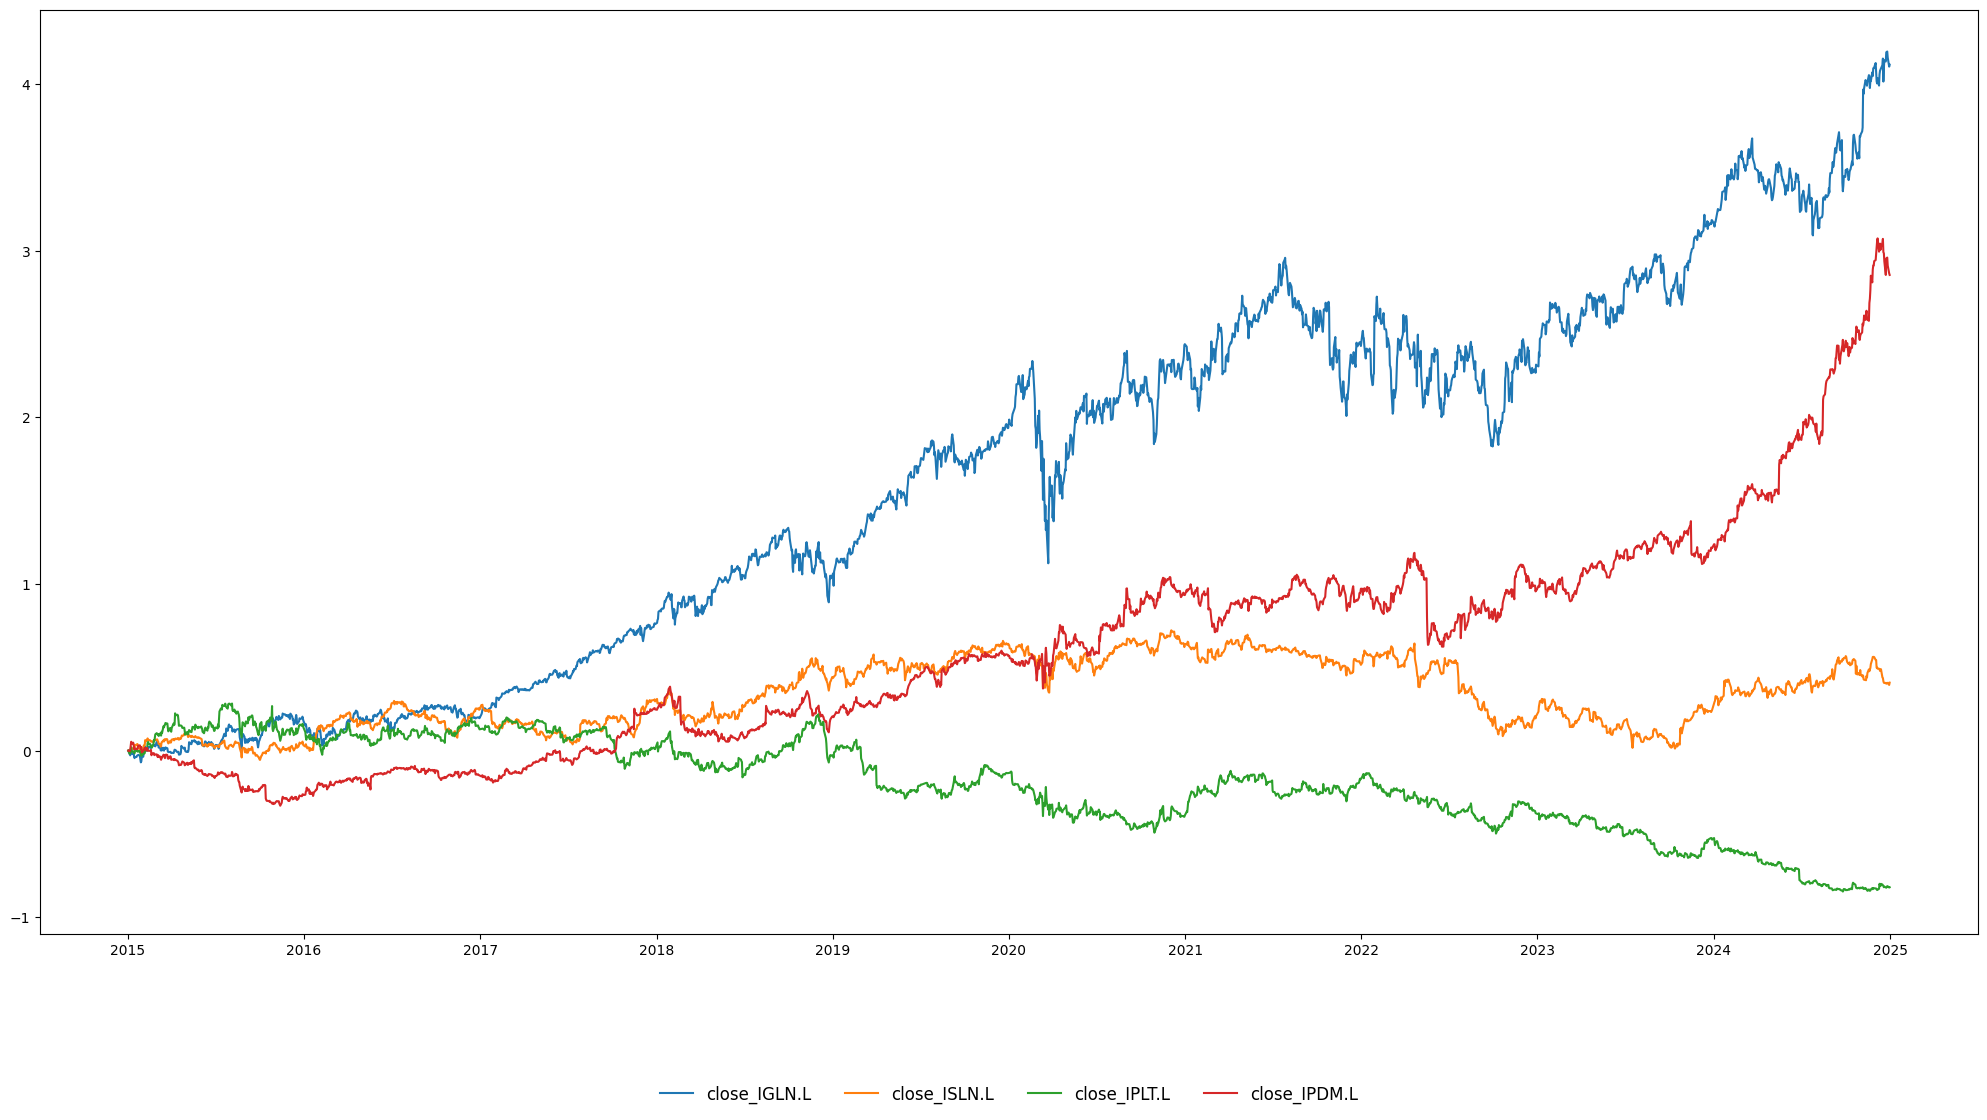

In [90]:
# Precious Metals Returns
plt.figure(figsize=(25,12))
for i in wide_df[['close_IGLN.L', 'close_ISLN.L', 'close_IPLT.L', 'close_IPDM.L']].columns:
    plt.plot(((wide_df[i].pct_change().fillna(0)+1).cumprod()-1), label=i)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=min(13, len(tics)), frameon=False, fontsize=12)
plt.show()


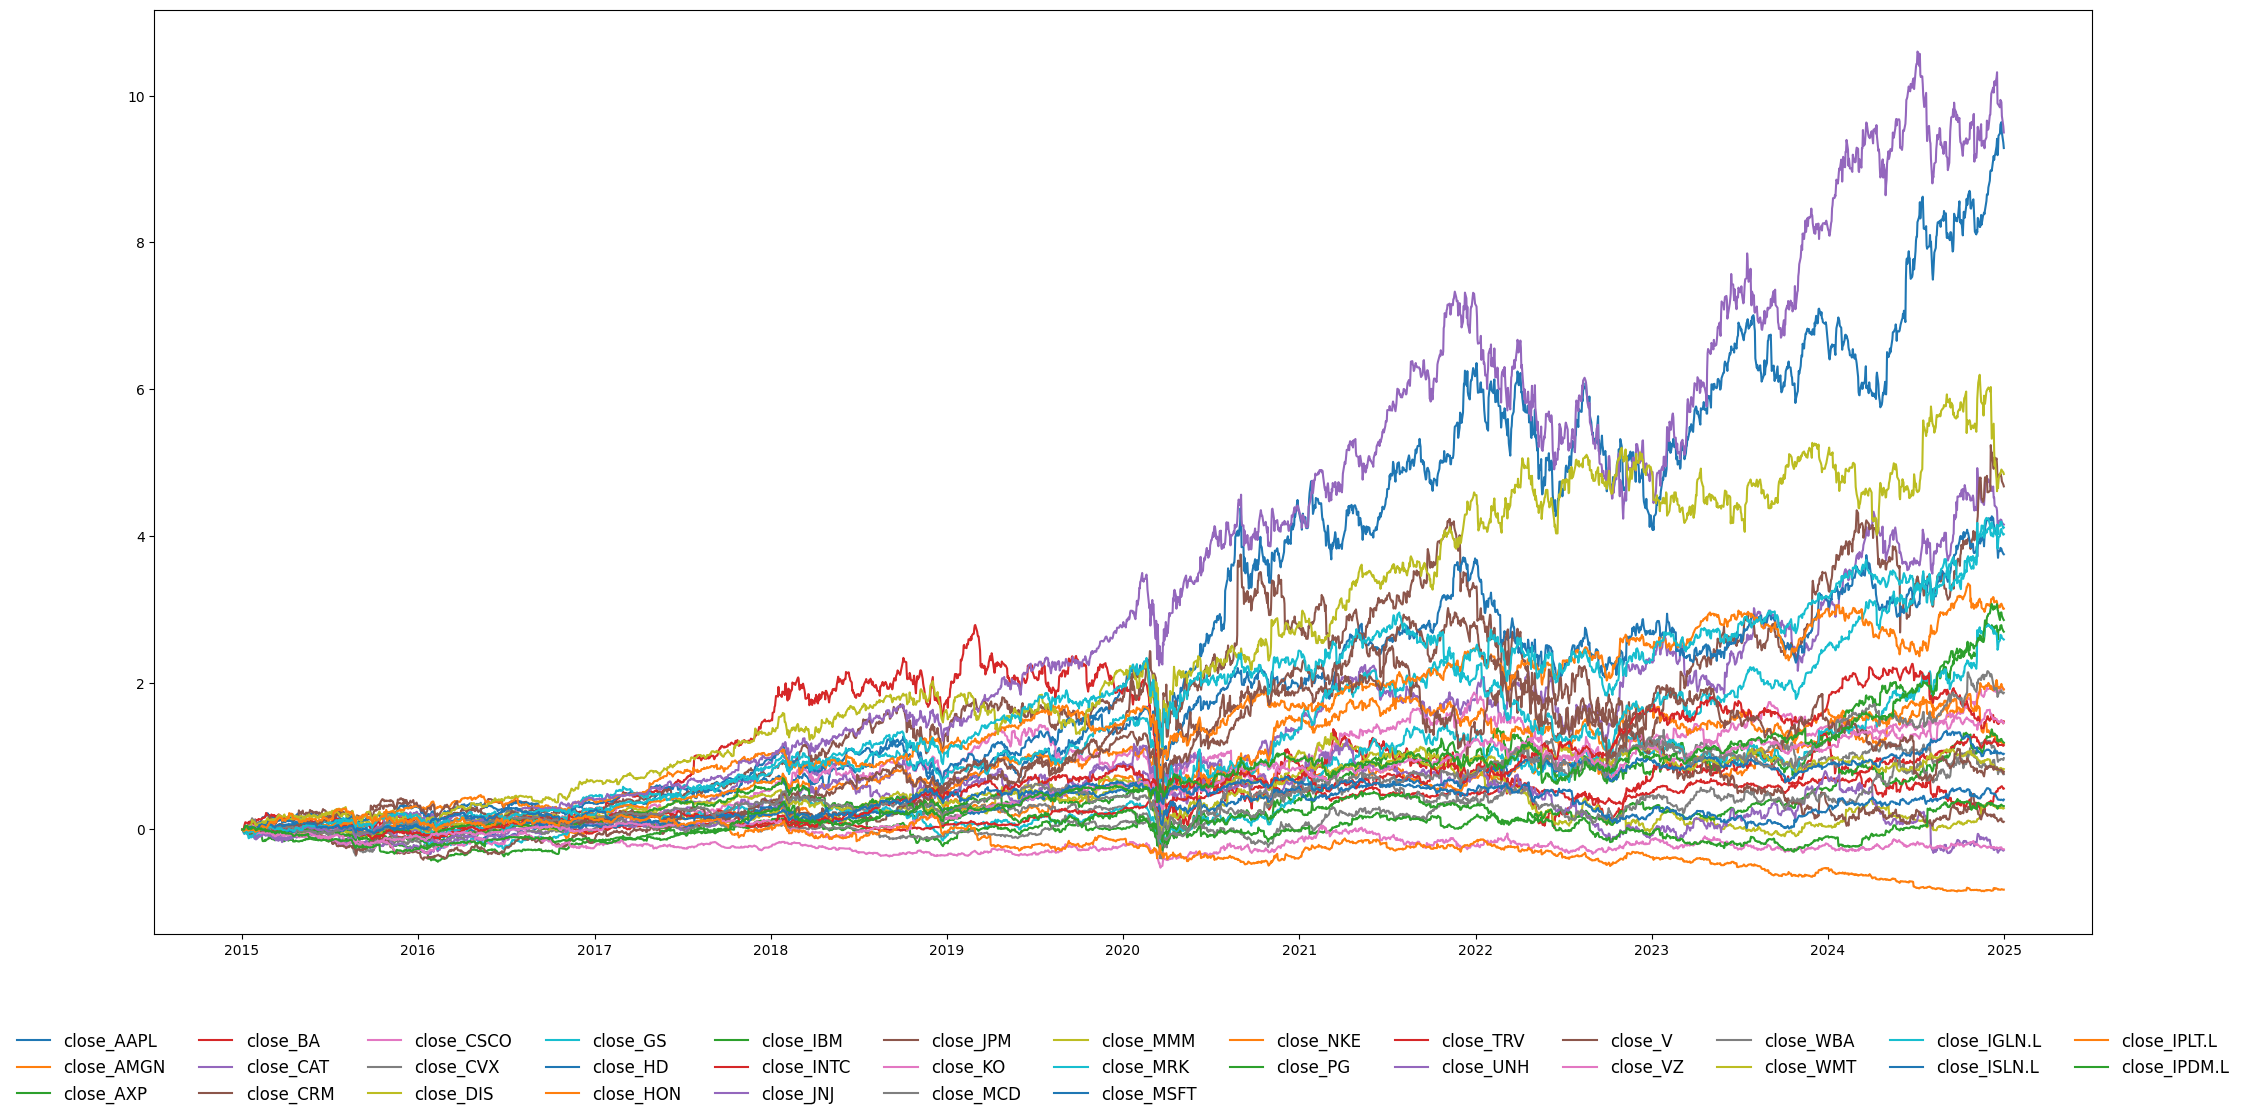

In [91]:
# All Assets Returns
plt.figure(figsize=(25,12))
for i in wide_df.filter(regex='close_').columns:
    plt.plot(((wide_df[i].pct_change().fillna(0)+1).cumprod()-1), label=i)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=min(13, len(tics)), frameon=False, fontsize=12)
plt.show()